# Общее описание


# Реализация: импорт библиотек и константы

In [1]:
import numpy as np
np.random.seed(0)
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
import tensorflow as tf
tf.random.set_seed(0)
from tensorflow import keras, data
import tensorflow_probability as tfp
from keras import layers, regularizers, activations
from keras.layers import Bidirectional
from keras import backend as K
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
row_mark = 1500
batch_size = 1
time_step = 1
lstm_h_dim = 8
z_dim = 4
epoch_num = 32
threshold = 50
alpha = 0.7
beta = 0.3

# extension parameters
N_constraintNet = 10
w_thres = 0.01
learning_rate = 1e-10

model_dir = "content/lstm_vae_model/"
image_dir = "content/lstm_vae_images/"

# Реализация: Encoder и Decoder

Encoder

In [3]:
class Encoder(layers.Layer):
    def __init__(self, time_step, x_dim, lstm_h_dim, z_dim, name='encoder', **kwargs):
        super(Encoder, self).__init__(name=name, **kwargs)

        self.encoder_inputs = keras.Input(shape=(time_step, x_dim))
        self.encoder_lstm = Bidirectional(layers.LSTM(lstm_h_dim, activation='sigmoid', name='encoder_lstm', stateful=True))
        self.z_mean = layers.Dense(z_dim, name='z_mean')
        self.z_logvar = layers.Dense(z_dim, name='z_log_var')
        self.z_sample = Sampling()

    def call(self, inputs,**kwargs):
        self.encoder_inputs = inputs
        hidden = self.encoder_lstm(self.encoder_inputs)
        mu_z = self.z_mean(hidden)
        logvar_z = self.z_logvar(hidden)
        z = self.z_sample((mu_z, logvar_z))
        return mu_z, logvar_z, z

    def get_config(self):
        config = super(Encoder, self).get_config()
        config.update({
            'name': self.name,
            'z_sample': self.z_sample.get_config()
        })
        return config

Decoder

In [4]:
class Decoder(layers.Layer):
    def __init__(self, time_step, x_dim, lstm_h_dim, z_dim, name='decoder', **kwargs):
        super(Decoder, self).__init__(name=name, **kwargs)

        self.z_inputs = layers.RepeatVector(time_step, name='repeat_vector')
        self.decoder_lstm_hidden = Bidirectional(layers.LSTM(lstm_h_dim, activation='sigmoid', return_sequences=True,
                                               name='decoder_lstm'))
        self.x_mean = layers.Dense(x_dim, name='x_mean')
        self.x_logvar = layers.Dense(x_dim, name='x_log_var')
        self.x_sample = Sampling()
        self.x_sigma = layers.Dense(x_dim, name='x_sigma', activation='tanh')

    def call(self, inputs,**kwargs):
        z = self.z_inputs(inputs)
        hidden = self.decoder_lstm_hidden(z)
        mu_x = self.x_mean(hidden)
        logvar_x = self.x_logvar(hidden)
        sigma_x = self.x_sigma(hidden)
        x_dash = self.x_sample((mu_x, logvar_x))
        return mu_x, sigma_x,x_dash

    def get_config(self):
        config = super(Decoder, self).get_config()
        config.update({
            'name': self.name
        })
        return config

# Реализация: ConstraintNet

Constraint Net

In [5]:
class ConstraintNet(keras.Model):
    def __init__(self, time_step, x_dim, z_dim, N, name='constraint_net', **kwargs):
        super(ConstraintNet, self).__init__(name=name, **kwargs)

        self.layer1 = layers.Dense(8, input_dim=x_dim, activation='relu')
        self.layer2 = layers.Dense(16, activation='relu')
        self.out = layers.Dense(z_dim * N, activation='relu')
        self.reshape = layers.Reshape((N, z_dim))

        self.N = N
        self.z_dim = z_dim

    def call(self, inputs, z):
        h = self.layer1(inputs)
        h = self.layer2(h)
        out = self.out(h)
        c_mat = self.reshape(out)
        w = tf.matmul(z, c_mat, transpose_b=True)
        thres = tf.constant(w_thres, shape=w.shape)
        mask = tf.cast(w > thres, dtype=tf.float32)
        w_dash = tf.multiply(w, mask)
        z_dash = tf.linalg.matmul(w_dash, c_mat)
        z_dash = tf.squeeze(z_dash, axis=1)
        return z_dash

    def cosine_similarity(self, X, Y):
        X_norm = tf.norm(X, axis=1)
        Y_norm = tf.norm(Y, axis=1)
        dot_prod = tf.reduce_sum(X * Y, 1)
        w = dot_prod / (X_norm * Y_norm)
        return w

# Реализация: VELC

VELC

In [6]:
loss_metric = keras.metrics.Mean(name='loss')
likelihood_metric = keras.metrics.Mean(name='log likelihood')

class VELC(keras.Model):
    def __init__(self, time_step, x_dim, lstm_h_dim, z_dim,N_constraintNet, name='velc', **kwargs):
        super(VELC, self).__init__(name=name, **kwargs)

        self.encoder = Encoder(time_step, x_dim, lstm_h_dim, z_dim, **kwargs)
        self.decoder = Decoder(time_step, x_dim, lstm_h_dim, z_dim, **kwargs)


        self.constraint_net_1 = ConstraintNet(time_step,x_dim,z_dim,N_constraintNet,name="constNet1",**kwargs)
        self.re_encoder = Encoder(time_step, x_dim, lstm_h_dim, z_dim,name="re_encoder",**kwargs)
        self.constraint_net_2 = ConstraintNet(time_step,x_dim,z_dim,N_constraintNet,name="constNet2",**kwargs)


    def call(self, inputs,**kwargs):
        mu_z, logvar_z, z = self.encoder(inputs)
        z_dash = self.constraint_net_1(inputs, z)
        mu_x, sigma_x, x_dash = self.decoder(z_dash)
        mu_re_z, logvar_re_z, re_z = self.re_encoder(x_dash)
        re_z_dash = self.constraint_net_2(x_dash, re_z)

        recons_loss = self.l2_NORM(inputs, x_dash)
        kl_loss_1 = self.kl_loss(logvar_z,mu_z)
        kl_loss_2 = self.kl_loss(logvar_re_z,mu_re_z)
        latent_loss = self.l2_NORM(z_dash, re_z_dash)
        total_loss = recons_loss + kl_loss_1 + kl_loss_2 + latent_loss


        anomaly_score = self.anomaly_score(inputs, x_dash, z_dash, re_z_dash)
        dist = tfp.distributions.Normal(loc=mu_x, scale=tf.abs(sigma_x))
        log_px = -dist.log_prob(inputs)

        return anomaly_score,total_loss, log_px


    def get_config(self):
        config = {
            'encoder': self.encoder.get_config(),
            'decoder': self.decoder.get_config(),
            'name': self.name
        }
        return config

    def l2_NORM(self, x, x_dash):
        recons_loss = tf.norm(x - x_dash,ord='euclidean', axis=1)
        return K.mean(recons_loss)

    def kl_loss(self, logvar_z, mu_z):
        kl_loss = -0.5 * (1 + logvar_z - tf.square(mu_z) - tf.exp(logvar_z))
        kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
        return kl_loss

    def mean_log_likelihood(self, log_px):
        log_px = K.reshape(log_px, shape=(log_px.shape[0], log_px.shape[2]))
        mean_log_px = K.mean(log_px, axis=1)
        return K.mean(mean_log_px, axis=0)

    def train_step(self, data):
        if isinstance(data, tuple):
            x = data[0]
        else:
            x = data

        with tf.GradientTape() as tape:
            anomaly_score,loss, log_px = self(x, training=True)
            mean_log_px = self.mean_log_likelihood(log_px)

        grads = tape.gradient(loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.trainable_variables))

        loss_metric.update_state(loss)
        likelihood_metric.update_state(mean_log_px)
        return {'loss': loss_metric.result(), 'log_likelihood': likelihood_metric.result()}


    def anomaly_score(self, x, x_dash, z_dash, re_z_dash):
        a1 = tf.squeeze(tf.norm(x - x_dash, ord=1, axis=1))
        a2 = tf.norm(z_dash - re_z_dash, ord=1, axis=0)
        ax = alpha * a1 + beta * a2
        ax_mean = K.mean(ax)
        return ax_mean

# Реализация: утилиты

Utils

In [7]:
def split_normalize_data(all_df):

    train_df = all_df[:row_mark]
    test_df = all_df[row_mark:]

    scaler = MinMaxScaler()
    scaler.fit(np.array(all_df)[:, 1:])
    train_scaled = scaler.transform(np.array(train_df)[:, 1:])
    test_scaled = scaler.transform(np.array(test_df)[:, 1:])
    return train_scaled, test_scaled

def reshape(da):
    return da.reshape(da.shape[0], time_step, da.shape[1]).astype("float32")

class Sampling(layers.Layer):
    def __init__(self, name='sampling_z'):
        super(Sampling, self).__init__(name=name)

    def call(self, inputs,**kwargs):
        mu, logvar = inputs
        print('mu: ', mu)
        sigma = K.exp(logvar * 0.3)
        epsilon = K.random_normal(shape=(mu.shape[0], z_dim), mean=0.0, stddev=0.0)
        return mu + epsilon * sigma

    def get_config(self):
        config = super(Sampling, self).get_config()
        config.update({'name': self.name})
        return config

# Запуск VELC на датасете
Читаем данные из файла и выводим их на график

Красная линия - начало аномалии

Dataset shape:  (6324, 5)


<Figure size 720x1440 with 0 Axes>

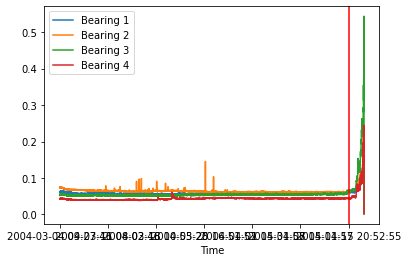

In [8]:
try:
  dataset = pd.read_csv("/content/bear3.csv")
  print("Dataset shape: ", dataset.shape)
  plt.figure(figsize=(10, 20))
  dataset.plot(x='Time', y=['Bearing 1', 'Bearing 2', 'Bearing 3', 'Bearing 4'])
  plt.axvline(x=6000, ymin=0.0, ymax=1, color='r') # начало аномалии
  plt.show()
except Exception:
  print("Dataset not found")


Делим датасет на тренировочную и тестовую выборки, нормализуем данные

In [9]:
all_df = pd.DataFrame(dataset)
train_scaled, test_scaled = split_normalize_data(all_df)
x_dim = train_scaled.shape[1]
print("Размер тренировочного и тестового датасета: ", train_scaled.shape, test_scaled.shape)

Размер тренировочного и тестового датасета:  (1500, 4) (4824, 4)


Запускаем модель

In [15]:
train_X = reshape(train_scaled)
test_X = reshape(test_scaled)

opt = keras.optimizers.Adam(learning_rate, epsilon=1e-6, amsgrad=True)

model = VELC(time_step, x_dim, lstm_h_dim, z_dim, N_constraintNet, dtype='float32')
model.compile(loss='binary_crossentropy', optimizer=opt)
train_dataset = data.Dataset.from_tensor_slices(train_X)
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(batch_size, drop_remainder=True)

history = model.fit(train_dataset, epochs=epoch_num, shuffle=False).history
model.summary()

anomaly_score_train, loss_train, train_log_px = model.predict(train_X, batch_size=1)

anomaly_score_test, loss_test, test_log_px = model.predict(test_X, batch_size=1)


Epoch 1/32
mu:  Tensor("velc/encoder/z_mean/BiasAdd:0", shape=(1, 4), dtype=float32)
mu:  Tensor("velc/decoder/x_mean/BiasAdd:0", shape=(1, 1, 4), dtype=float32)
mu:  Tensor("velc/re_encoder/z_mean/BiasAdd:0", shape=(1, 4), dtype=float32)


mu:  Tensor("velc/encoder/z_mean/BiasAdd:0", shape=(1, 4), dtype=float32)
mu:  Tensor("velc/decoder/x_mean/BiasAdd:0", shape=(1, 1, 4), dtype=float32)
mu:  Tensor("velc/re_encoder/z_mean/BiasAdd:0", shape=(1, 4), dtype=float32)


1500/1500 [==============================] - 16s 6ms/step - loss: 1.3503 - log_likelihood: 15.5200
Epoch 2/32
1500/1500 [==============================] - 9s 6ms/step - loss: 1.3546 - log_likelihood: 15.5998
Epoch 3/32
1500/1500 [==============================] - 9s 6ms/step - loss: 1.3589 - log_likelihood: 15.6784
Epoch 4/32
1500/1500 [==============================] - 9s 6ms/step - loss: 1.3631 - log_likelihood: 15.7558
Epoch 5/32
1500/1500 [==============================] - 9s 6ms/step - loss: 1.3673 - log_likelihood: 15.8322
Epoch 6/32
1500/1500 [==============================] - 8s 6ms/step - loss: 1.3714 - log_likelihood: 15.9076
Epoch 7/32
1500/1500 [==============================] - 9s 6ms/step - loss: 1.3754 - log_likelihood: 15.9821
Epoch 8/32
1500/1500 [==============================] - 8s 5ms/step - loss: 1.3794 - log_likelihood: 16.0553
Epoch 9/32
1500/1500 [==============================] - 9s 6ms/step - loss: 1.3834 - log_likelihood: 16.1278
Epoch 10/32
1500/1500 [======

# Вывод результатов
Красная линия - начало аномалии в датасете

Оранжевый график - anomaly score на тренировочном датасете

Синий график - anomaly score на тестовом датасете

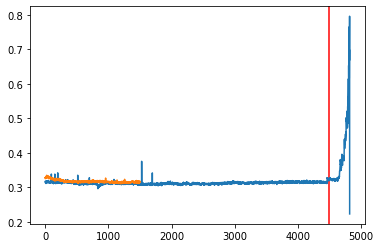

In [17]:
plt.axvline(x=4500, ymin=0.0, ymax=1, color='r') # начало аномалии

df_test_anomaly = pd.DataFrame()
df_test_anomaly['test_anomaly'] = anomaly_score_test
df_test_anomaly[df_test_anomaly.replace([np.inf, -np.inf], np.nan).notnull().all(axis=1)]
df_test_anomaly['test_anomaly'] = df_test_anomaly['test_anomaly'].astype(float)
df_test_anomaly['test_anomaly'].plot()

df_train_anomaly = pd.DataFrame()
df_train_anomaly['train_anomaly'] = anomaly_score_train
df_train_anomaly[df_train_anomaly.replace([np.inf, -np.inf], np.nan).notnull().all(axis=1)]
df_train_anomaly['train_anomaly'] = df_train_anomaly['train_anomaly'].astype(float)
df_train_anomaly['train_anomaly'].plot()

